# Lab 3 — dimensionality reduction

In [374]:
import json
import matplotlib.pyplot as plt
import numpy as np
from pyspark.mllib.linalg.distributed import RowMatrix
from operator import itemgetter
import pickle

%matplotlib inline
plt.style.use("ggplot")

In [3]:
!hdfs dfs -cat /ix/ml-20m/genome-tags.txt | tail -n 2

{"tagId": 1127, "tag": "zombie"}
{"tagId": 1128, "tag": "zombies"}


In [37]:
!hdfs dfs -cat /ix/ml-20m/movies.txt | tail -n 2

{"genres": ["(no genres listed)"], "movieId": 131260, "title": "Rentun Ruusu (2001)"}
{"genres": ["Adventure", "Fantasy", "Horror"], "movieId": 131262, "title": "Innocence (2014)"}


In [4]:
data = sc.textFile("/ix/ml-20m/genome-tags.txt").map(json.loads)
tag2name = dict(data.map(itemgetter("tagId", "tag")).collect())

### Playing with data

In [5]:
data.take(10)

[{'tag': '007', 'tagId': 1},
 {'tag': '007 (series)', 'tagId': 2},
 {'tag': '18th century', 'tagId': 3},
 {'tag': '1920s', 'tagId': 4},
 {'tag': '1930s', 'tagId': 5},
 {'tag': '1950s', 'tagId': 6},
 {'tag': '1960s', 'tagId': 7},
 {'tag': '1970s', 'tagId': 8},
 {'tag': '1980s', 'tagId': 9},
 {'tag': '19th century', 'tagId': 10}]

In [6]:
movies = sc.textFile("/ix/ml-20m/movies.txt").map(json.loads)

In [7]:
movies.take(10)

[{'genres': ['Adventure', 'Animation', 'Children', 'Comedy', 'Fantasy'],
  'movieId': 1,
  'title': 'Toy Story (1995)'},
 {'genres': ['Adventure', 'Children', 'Fantasy'],
  'movieId': 2,
  'title': 'Jumanji (1995)'},
 {'genres': ['Comedy', 'Romance'],
  'movieId': 3,
  'title': 'Grumpier Old Men (1995)'},
 {'genres': ['Comedy', 'Drama', 'Romance'],
  'movieId': 4,
  'title': 'Waiting to Exhale (1995)'},
 {'genres': ['Comedy'],
  'movieId': 5,
  'title': 'Father of the Bride Part II (1995)'},
 {'genres': ['Action', 'Crime', 'Thriller'],
  'movieId': 6,
  'title': 'Heat (1995)'},
 {'genres': ['Comedy', 'Romance'], 'movieId': 7, 'title': 'Sabrina (1995)'},
 {'genres': ['Adventure', 'Children'],
  'movieId': 8,
  'title': 'Tom and Huck (1995)'},
 {'genres': ['Action'], 'movieId': 9, 'title': 'Sudden Death (1995)'},
 {'genres': ['Action', 'Adventure', 'Thriller'],
  'movieId': 10,
  'title': 'GoldenEye (1995)'}]

In [8]:
movies.count()

27278

In [9]:
genres_count = movies.flatMap(lambda x: x['genres'])

In [10]:
genres_count = genres_count.distinct()

In [11]:
genres_count.take(10)

['Children',
 'Fantasy',
 'Romance',
 'Drama',
 'Action',
 'Thriller',
 'Horror',
 'Sci-Fi',
 'IMAX',
 'Documentary']

In [12]:
genres_count.count()

20

In [13]:
number_of_tags = data.count()
print(number_of_tags)

1128


In [14]:
data.take(20)

[{'tag': '007', 'tagId': 1},
 {'tag': '007 (series)', 'tagId': 2},
 {'tag': '18th century', 'tagId': 3},
 {'tag': '1920s', 'tagId': 4},
 {'tag': '1930s', 'tagId': 5},
 {'tag': '1950s', 'tagId': 6},
 {'tag': '1960s', 'tagId': 7},
 {'tag': '1970s', 'tagId': 8},
 {'tag': '1980s', 'tagId': 9},
 {'tag': '19th century', 'tagId': 10},
 {'tag': '3d', 'tagId': 11},
 {'tag': '70mm', 'tagId': 12},
 {'tag': '80s', 'tagId': 13},
 {'tag': '9/11', 'tagId': 14},
 {'tag': 'aardman', 'tagId': 15},
 {'tag': 'aardman studios', 'tagId': 16},
 {'tag': 'abortion', 'tagId': 17},
 {'tag': 'absurd', 'tagId': 18},
 {'tag': 'action', 'tagId': 19},
 {'tag': 'action packed', 'tagId': 20}]

In [312]:
tag2name[1]

'007'

In [16]:
tag_scores = sc.textFile("/ix/ml-20m/genome-scores.txt").map(json.loads)

In [17]:
tag_scores.take(10)

[{'movieId': 1, 'relevance': 0.025000000000000022, 'tagId': 1},
 {'movieId': 1, 'relevance': 0.025000000000000022, 'tagId': 2},
 {'movieId': 1, 'relevance': 0.057750000000000024, 'tagId': 3},
 {'movieId': 1, 'relevance': 0.09675, 'tagId': 4},
 {'movieId': 1, 'relevance': 0.14675, 'tagId': 5},
 {'movieId': 1, 'relevance': 0.21700000000000003, 'tagId': 6},
 {'movieId': 1, 'relevance': 0.067, 'tagId': 7},
 {'movieId': 1, 'relevance': 0.26275000000000004, 'tagId': 8},
 {'movieId': 1, 'relevance': 0.262, 'tagId': 9},
 {'movieId': 1, 'relevance': 0.03199999999999997, 'tagId': 10}]

In [18]:
tag_scores.count()

11709768

In [19]:
tag_counts = tag_scores.map(lambda a: (a['movieId'], 1))

In [20]:
tag_counts = tag_counts.reduceByKey(lambda x,y: x+y)

In [21]:
tag_counts.take(10)

[(6, 1128),
 (12, 1128),
 (18, 1128),
 (24, 1128),
 (30, 1128),
 (36, 1128),
 (42, 1128),
 (48, 1128),
 (54, 1128),
 (60, 1128)]

In [22]:
tag_counts.count()

10381

only 10381 out of 27278 movies have tags o_0

In [23]:
ratings = sc.textFile("/ix/ml-20m/ratings.txt").map(json.loads)

In [24]:
ratings.take(10)

[{'movieId': 2, 'rating': 3.5, 'timestamp': 1112486027, 'userId': 1},
 {'movieId': 29, 'rating': 3.5, 'timestamp': 1112484676, 'userId': 1},
 {'movieId': 32, 'rating': 3.5, 'timestamp': 1112484819, 'userId': 1},
 {'movieId': 47, 'rating': 3.5, 'timestamp': 1112484727, 'userId': 1},
 {'movieId': 50, 'rating': 3.5, 'timestamp': 1112484580, 'userId': 1},
 {'movieId': 112, 'rating': 3.5, 'timestamp': 1094785740, 'userId': 1},
 {'movieId': 151, 'rating': 4.0, 'timestamp': 1094785734, 'userId': 1},
 {'movieId': 223, 'rating': 4.0, 'timestamp': 1112485573, 'userId': 1},
 {'movieId': 253, 'rating': 4.0, 'timestamp': 1112484940, 'userId': 1},
 {'movieId': 260, 'rating': 4.0, 'timestamp': 1112484826, 'userId': 1}]

In [25]:
ratings.count()

20000263

In [26]:
movie_name_lengths = movies.map(lambda x: x['title'])

In [412]:
movie_name_lengths.takeOrdered(5, lambda x: -len(x))

['Godzilla, Mothra, and King Ghidorah: Giant Monsters All-Out Attack (Gojira, Mosura, Kingu Gidorâ: Daikaijû sôkôgeki) (Godzilla, Mothra and King Ghidorah: Giant Monsters All-Out Attack) (2001)',
 "Dragon Ball Z the Movie: The World's Strongest (a.k.a. Dragon Ball Z: The Strongest Guy in The World) (Doragon bôru Z: Kono yo de ichiban tsuyoi yatsu) (1990)",
 'Strange Behaviour of Sexually Mature City Slickers at Mating Season, The (Das merkwürdige Verhalten geschlechtsreifer Großstädter zur Paarungszeit) (1998)',
 'Dragon Ball Z: Bardock - The Father of Goku (Doragon bôru Z: Tatta hitori no saishuu kessen - Furiiza ni itonda Z senshi Kakarotto no chichi) (1990)',
 'Revolutionary Girl Utena: Adolescence of Utena (a.k.a. Revolutionary Girl Utena the Movie) (Shoujo kakumei Utena: Adolescence mokushiroku) (1999)']

so there are 'holes' in movieIds

### Excercise 3.1

In [34]:
tagged_movies = tag_scores.map(lambda x: x['movieId']).distinct()

In [43]:
tagged_movies.take(10)

[6672, 6678, 6684, 6690, 6696, 6702, 6708, 6714, 6720, 6732]

In [35]:
M = len(tag2name)
N = tagged_movies.count()

In [42]:
print(M, N)

1128 10381


In [43]:
mat = np.zeros((M, N))

In [ ]:
with open(".pickle", "rb") as f:
    matt = pickle.load(f, encoding="utf-8")

In [61]:
# construct a way to convert movieId to its matrix column number
tagged_movies_list = sorted(tagged_movies.collect())

In [62]:
len(tagged_movies_list)

10381

In [79]:
tag_scores_table = tag_scores.map(lambda x: (x['movieId'], {'tagId': x['tagId'], 'relevance': x['relevance']})).groupByKey().collect()

In [83]:
for movie_scores in tag_scores_table:
    movieId = movie_scores[0]
    for tag in movie_scores[1]:
        tagId = tag['tagId']
        relevance = tag['relevance']
        mat[tagId-1][tagged_movies_list.index(movieId)] = relevance
    

In [84]:
mat

array([[ 0.025  ,  0.03975,  0.0435 , ...,  0.042  ,  0.05975,  0.05325],
       [ 0.025  ,  0.04375,  0.05475, ...,  0.03175,  0.10375,  0.08625],
       [ 0.05775,  0.03775,  0.028  , ...,  0.017  ,  0.1785 ,  0.017  ],
       ..., 
       [ 0.03625,  0.01475,  0.0195 , ...,  0.0095 ,  0.51925,  0.01575],
       [ 0.07775,  0.09025,  0.097  , ...,  0.0755 ,  0.067  ,  0.1145 ],
       [ 0.023  ,  0.01875,  0.0185 , ...,  0.01625,  0.01725,  0.02175]])

In [109]:
# variance in each dimension
variance_in_dimensions = np.var(mat, axis=1)

In [105]:
print (variance_in_dimensions)

[ 0.00489995  0.00374062  0.01184875 ...,  0.01882639  0.01105271
  0.00657968]


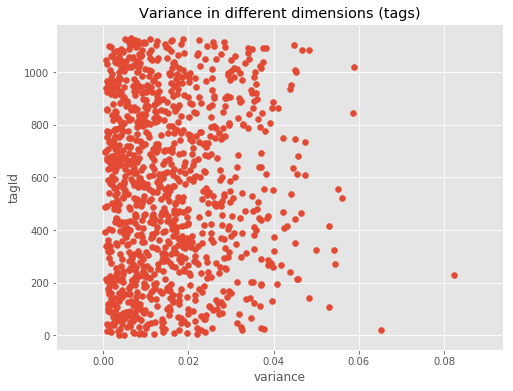

In [110]:
plt.figure(figsize=(8, 6))
plt.scatter(variance_in_dimensions, list(tag2name))
plt.title("Variance in different dimensions (tags)")
plt.xlabel("variance")
plt.ylabel("tagId")
plt.show()

In [111]:
cov_mat = np.cov(mat)

In [116]:
cov_mat.shape

(1128, 1128)

In [131]:
cov_mat

array([[ 0.00490042,  0.00327346, -0.00030115, ...,  0.00016838,
        -0.00016172, -0.00014599],
       [ 0.00327346,  0.00374098, -0.00023234, ...,  0.00011866,
        -0.00015645, -0.00014514],
       [-0.00030115, -0.00023234,  0.01184989, ...,  0.00130349,
        -0.00112118, -0.00035662],
       ..., 
       [ 0.00016838,  0.00011866,  0.00130349, ...,  0.0188282 ,
        -0.00114338, -0.00032847],
       [-0.00016172, -0.00015645, -0.00112118, ..., -0.00114338,
         0.01105378,  0.00659333],
       [-0.00014599, -0.00014514, -0.00035662, ..., -0.00032847,
         0.00659333,  0.00658031]])

In [294]:
eig_values, eig_vectors = np.linalg.eigh(cov_mat)
eig_values = np.flip(eig_values, axis=0) # to have them in descending order
eig_vectors = np.flip(eig_vectors, axis=1)

In [145]:
print(eig_values[:10])

[ 2.75337748  1.22147104  0.99605152  0.6621755   0.58572979  0.47432794
  0.46142463  0.39720884  0.34151865  0.28889341]


In [295]:
eig_vectors

array([[-0.00572728, -0.01383799,  0.00124553, ...,  0.0062789 ,
        -0.0053407 ,  0.00205699],
       [-0.00478882, -0.01048045,  0.00206112, ...,  0.00347284,
        -0.00303118, -0.00078554],
       [ 0.01246704,  0.00278201,  0.02393293, ...,  0.00037798,
        -0.00104207,  0.00044356],
       ..., 
       [ 0.01719115, -0.00551248,  0.03252862, ...,  0.00263286,
        -0.00050236,  0.00093566],
       [-0.01026643, -0.01417361, -0.0399581 , ...,  0.00429738,
         0.01518848, -0.00228662],
       [-0.00137267, -0.00551606, -0.01634403, ..., -0.00067457,
        -0.01100711,  0.00059397]])

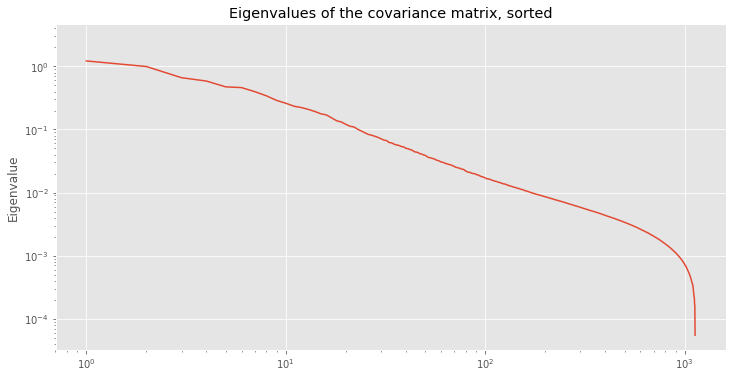

In [255]:
plt.figure(figsize=(12, 6))
plt.loglog(eig_values)
plt.title("Eigenvalues of the covariance matrix, sorted")
plt.ylabel("Eigenvalue")
plt.show()

In [256]:
total = sum(eig_values)
captured_variability = [eigv/total*100 for eigv in eig_values]
cum_captured_variability = np.cumsum(captured_variability).tolist()

In [258]:
print(cum_captured_variability)

[16.09984018236562, 23.242154927609604, 29.066372780783365, 32.938315441861505, 36.363256627599206, 39.13679716269937, 41.83488808944758, 44.15748964614456, 46.15445365987529, 47.84370176444964, 49.36874596327928, 50.735851701850905, 52.0359409396258, 53.25084172910521, 54.37777277609013, 55.41492257023864, 56.40872215355756, 57.30108086542617, 58.10408638274457, 58.87277009833421, 59.57852338467013, 60.236618920890365, 60.8766154687838, 61.46232196927872, 62.01345142280321, 62.52886198499363, 63.016720518374534, 63.48996457292495, 63.94634794989435, 64.38422008458683, 64.8015603953651, 65.19958207236014, 65.58932990126416, 65.95269353174798, 66.3108379971456, 66.65145090563249, 66.98488598691523, 67.31049352864947, 67.6242129171575, 67.9338933748402, 68.2276505818317, 68.51789165664485, 68.79842435039133, 69.0732890799885, 69.33381118898085, 69.59054653343307, 69.84284646445137, 70.08436219864724, 70.32328442853435, 70.55417177386325, 70.78227682300043, 71.00037766985092, 71.210918977

In [261]:
twothirds = [i for i in range(1,len(cum_captured_variability)) if cum_captured_variability[i] > 200/3 and cum_captured_variability[i-1] < 200/3][0]
print(twothirds)

36


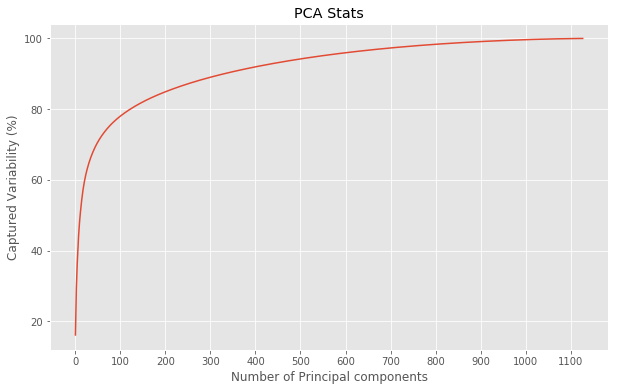

In [224]:
plt.figure(figsize=(10,6))
plt.plot(range(len(cum_captured_variability)), cum_captured_variability)
plt.title("PCA Stats")
plt.xticks(np.arange(0, 1200, step=100))
plt.xlabel("Number of Principal components")
plt.ylabel("Captured Variability (%)")
plt.show()

In [235]:
sample_points = [5, 15, 35, 60, 80, 100, 200]
sample_captured_variability = [cum_captured_variability[x-1] for x in sample_points]

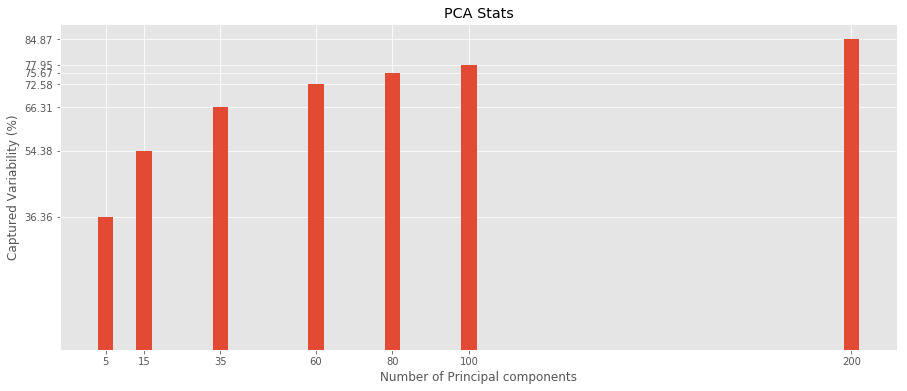

In [236]:
plt.figure(figsize=(15,6))
plt.title("PCA Stats")
plt.bar(sample_points, sample_captured_variability, width=4)
plt.xticks(sample_points)
plt.yticks(sample_captured_variability)
plt.xlabel("Number of Principal components")
plt.ylabel("Captured Variability (%)")
plt.show()

We need 36 components to capture 2/3 of the variability in our data.

### Excercise 3.2

In [361]:
first_five_eig_vectors = eig_vectors.T[:5]
for i, princ_dir in enumerate(first_five_eig_vectors):
    sorted_coordinates = princ_dir.argsort()
    highest10 = sorted_coordinates[-10:][::-1]
    lowest10 = sorted_coordinates[:10]
    print("Principal Direction", i+1)
    print("               Highest {:40s} Lowest".format(""))
    for i in range(10):
        [tag2name[tag+1] for tag in np.where(princ_dir == max(princ_dir))[0]]
        print("{:25s}{:20f}{:5}{:20s}{:15f}".format(tag2name[highest10[i]+1], princ_dir[highest10[i]], "", tag2name[lowest10[i]+1], princ_dir[lowest10[i]]))
    print("----------------------------")

Principal Direction 1
               Highest                                          Lowest
talky                                0.104587     predictable               -0.083331
social commentary                    0.101853     so bad it's funny         -0.068450
criterion                            0.101389     bad plot                  -0.065058
imdb top 250                         0.099906     silly                     -0.061452
great acting                         0.098764     silly fun                 -0.060956
drama                                0.098425     horrible                  -0.054783
oscar (best directing)               0.097419     franchise                 -0.053759
bleak                                0.096656     lame                      -0.046250
dramatic                             0.096186     big budget                -0.045794
cinematography                       0.095898     comedy                    -0.045540
----------------------------
Principal Directio

#### Concepts

These look like ...

In [371]:
tags_in_5_dimensions = {}
for tag in tag2name:
    coords = [princ_dir[tag-1] for princ_dir in first_five_eig_vectors]
    tags_in_5_dimensions[tag2name[tag]] = coords

In [376]:
pickle_out = open("tags_in_5_dimensions.pickle","wb")
pickle.dump(tags_in_5_dimensions, pickle_out)
pickle_out.close()

In [377]:
pickle_out = open("mat.pickle","wb")
pickle.dump(mat, pickle_out)
pickle_out.close()

### Excercise 3.3

In [378]:
with open("selected-movies.pickle", "rb") as f:
    selected_movies = pickle.load(f, encoding="utf-8")

In [382]:
selected_movies = list(selected_movies)

In [383]:
selected_movies

[(780, 'Independence Day (a.k.a. ID4) (1996)', 0.6),
 (5349, 'Spider-Man (2002)', 0.89),
 (2571, 'Matrix, The (1999)', 0.87),
 (318, 'Shawshank Redemption, The (1994)', 0.91),
 (2329, 'American History X (1998)', 0.83),
 (5147, 'Wild Strawberries (Smultronstället) (1957)', 0.95),
 (55444, 'Control (2007)', 0.87),
 (32296, 'Miss Congeniality 2: Armed and Fabulous (2005)', 0.15),
 (43930, 'Just My Luck (2006)', 0.13),
 (4658, 'Santa Sangre (1989)', 0.85),
 (6774, 'Videodrome (1983)', 0.78),
 (3967, 'Billy Elliot (2000)', 0.85),
 (114028, 'Pride (2014)', 0.92),
 (480, 'Jurassic Park (1993)', 0.93),
 (260, 'Star Wars: Episode IV - A New Hope (1977)', 0.93),
 (4700, 'Princess Diaries, The (2001)', 0.47),
 (527, "Schindler's List (1993)", 0.96),
 (2959, 'Fight Club (1999)', 0.79),
 (6132, 'New York Ripper, The (Squartatore di New York, Lo) (1982)', 0.17),
 (2858, 'American Beauty (1999)', 0.88),
 (6016, 'City of God (Cidade de Deus) (2002)', 0.9),
 (94018, 'Battleship (2012)', 0.34),
 (5687,

In [407]:
projections = [[np.dot(mat[:, tagged_movies_list.index(movie[0])], first_five_eig_vectors[i]) for movie in selected_movies] for i in range(5)]

In [392]:
from bokeh.io import show, output_notebook
from bokeh.plotting import figure, ColumnDataSource
from bokeh.models import HoverTool, ResetTool, PanTool, WheelZoomTool, SaveTool
output_notebook()

Loading BokehJS ...

In [408]:
# Continuous colors
from matplotlib.colors import rgb2hex 
cmap = plt.get_cmap('viridis')

def to_red_green(val):
    val = val * 100
    red = 255 if val<50 else round(256 - (val-50)*5.12)
    green = 255 if val>50 else round((val)*5.12)
    return rgb2hex([red/255, green/255, 0])

source = ColumnDataSource(
    data={
        "x": projections[0],
        "y": projections[1],
        "name": [x[1] for x in selected_movies],
        "color": [to_red_green(x[2]) for x in selected_movies],
        "rtscore": [x[2] for x in selected_movies]
    })

hover = HoverTool(
    tooltips=[
        ("Name", "@name"),
        ("RT Score", "@rtscore")
    ])
tools = [hover, ResetTool(), PanTool(), WheelZoomTool(), SaveTool()]

p = figure(plot_width=720, plot_height=480, tools=tools, title="Mouse over the dots")
p.circle("x", "y", source=source, size=15, color="color", alpha=0.8)
show(p, notebook_handle=True)

on the right are the top rated and well produced films, vs to the left there are films considered 'lame'. The lower half contains fast-paced films with action and cgi, while those to the top represent the ones more related to emotions (romance, drama type)

In [411]:
# Continuous colors
from matplotlib.colors import rgb2hex 
cmap = plt.get_cmap('viridis')

def to_red_green(val):
    val = val * 100
    red = 255 if val<50 else round(256 - (val-50)*5.12)
    green = 255 if val>50 else round((val)*5.12)
    return rgb2hex([red/255, green/255, 0])

source = ColumnDataSource(
    data={
        "x": projections[2],
        "y": projections[3],
        "name": [x[1] for x in selected_movies],
        "color": [to_red_green(x[2]) for x in selected_movies],
        "rtscore": [x[2] for x in selected_movies]
    })

hover = HoverTool(
    tooltips=[
        ("Name", "@name"),
        ("RT Score", "@rtscore")
    ])
tools = [hover, ResetTool(), PanTool(), WheelZoomTool(), SaveTool()]

p = figure(plot_width=720, plot_height=480, tools=tools, title="Mouse over the dots")
p.circle("x", "y", source=source, size=15, color="color", alpha=0.8)
show(p, notebook_handle=True)